In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import model_selection
from sklearn import metrics
import time
import tensorflow as tf
import shap
import numpy as np
tf.compat.v1.disable_v2_behavior()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# load data
df = pd.read_csv('ToN-IoT_balanced_smote.csv')

In [3]:
X = df.drop(['label','type'], axis=1)
Y = df['label']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

# convert Y to int
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)

# reshape the data for LSTM
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# convert all to numpy arrays
X_train = np.asarray(X_train).astype(np.float32)
# Y_train = np.asarray(Y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
# Y_test = np.asarray(Y_test).astype(np.float32)

In [4]:
# load binary model
from keras.models import load_model
model = load_model('ton_bin_lstm_smote.h5')

2023-12-24 14:35:44.489775: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-12-24 14:35:44.532618: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_5/lstm_cell/kernel/Assign' id:366 op device:{requested: '', assigned: ''} def:{{{node lstm_5/lstm_cell/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_5/lstm_cell/kernel, lstm_5/lstm_cell/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-24 14:35:44.647130: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/kernel/v/Assign' id:808 op device:{requested: '', assigned: ''} def:{{{node dense_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](d

In [5]:
import matplotlib.pyplot as plt
tf.compat.v1.disable_eager_execution()

# get keras session of the model
sess = tf.compat.v1.keras.backend.get_session()

# Create a DeepExplainer with Python lists
explainer = shap.DeepExplainer(model, X_train[:100], session=sess)

# Get Shapley values with Python lists
shap_values = explainer.shap_values(X_test[:10000])

# Rest of your code
shap.getjs()
shap.initjs()
features = X.columns.to_list()

# Use Python lists for force_plot
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


111


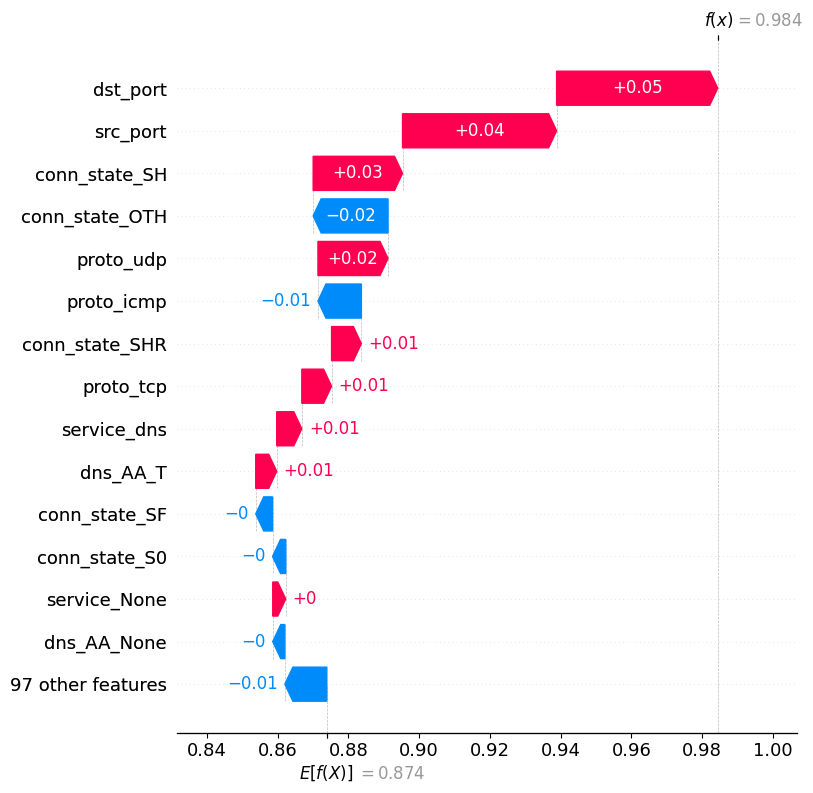

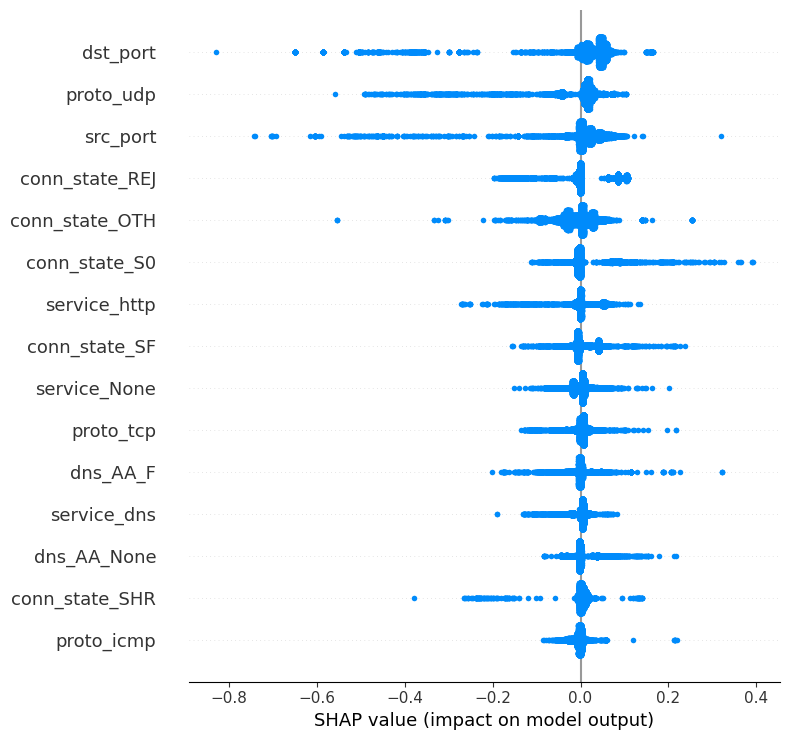

In [6]:
# display shap graph 
vals = shap_values[0]
# reshaping the values
vals = vals.reshape((vals.shape[0], vals.shape[2]))
print(len(vals[0]))
shap.waterfall_plot(shap.Explanation(values=vals[0], base_values=explainer.expected_value[0], feature_names=features), max_display = 15)
# shap.bar_plot(vals[0], feature_names=features, max_display=15)
shap.summary_plot(vals, feature_names=features, max_display=15)

In [7]:
# get top 15 features
top_15 = np.argsort(np.sum(np.abs(vals), axis=0))[-15:]
print(top_15)

[ 9 34 36 15 35 10 12 32 18 28 22 23  0 11  1]


In [8]:
df2 = df.copy()
# keep only top 20 features
df2 = df2.iloc[:,top_15]
df2['label'] = df['label']
df2

,label,conn_state_SH,dns_AA_F,service_dhcp,conn_state_SHR,proto_icmp,proto_udp,conn_state_S3,service_gssapi,conn_state_RSTRH,service_ssl,conn_state_OTH,src_port,proto_tcp,dst_port
0,0.0,False,False,False,False,False,False,False,False,False,False,True,0.101952,True,3.799303
1,0.0,False,False,False,False,False,True,False,False,False,False,False,2.558822,False,1.118792
2,0.0,False,False,False,False,False,False,False,False,False,False,True,0.101790,True,3.713672
3,0.0,False,False,False,False,False,False,False,False,False,False,True,1.856906,True,0.753177
4,0.0,False,False,False,True,False,True,False,False,False,False,False,2.523521,False,0.003801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,1.0,True,False,False,False,False,False,False,False,False,False,False,3.279039,True,0.005737
2999996,1.0,False,True,False,False,False,True,False,False,False,False,False,1.823237,False,0.003801
2999997,1.0,True,False,False,False,False,False,False,False,False,False,False,2.563471,True,0.005737
2999998,1.0,True,False,False,False,False,False,False,False,False,False,False,1.853248,True,0.005737


In [9]:
# save df2
df2.to_csv('ToN-IoT_balanced_smote_top15.csv', index=False)

In [10]:
# train an lstm model on the data
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import model_selection
from sklearn import metrics
X = df2.drop(['label'], axis=1)
Y = df2['label']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

# convert Y to int
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)

# reshape the data for LSTM
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# convert all to numpy arrays
X_train = np.asarray(X_train).astype(np.float32)
# Y_train = np.asarray(Y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
# Y_test = np.asarray(Y_test).astype(np.float32)

# define the model and add recurrent dropout
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation = 'relu'))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True, activation = 'relu'))
model.add(Dropout(0.1))
model.add(LSTM(64, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# train the model
start = time.time()
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test), shuffle=True)
end = time.time()
print("Time taken to train the model: ", end - start)

Train on 2400000 samples, validate on 600000 samples
Epoch 1/10


2023-12-24 14:36:35.486986: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/lstm/lstm_cell/recurrent_kernel/v/Assign' id:4059 op device:{requested: '', assigned: ''} def:{{{node training/Adam/lstm/lstm_cell/recurrent_kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/lstm/lstm_cell/recurrent_kernel/v, training/Adam/lstm/lstm_cell/recurrent_kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2398976/2400000 [============================>.] - ETA: 0s - loss: 0.1129 - acc: 0.9636

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2023-12-24 14:38:27.109280: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_1/mul' id:2944 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2400000/2400000 [==============================] - 120s 50us/sample - loss: 0.1129 - acc: 0.9636 - val_loss: 0.0927 - val_acc: 0.9716
Epoch 2/10
2400000/2400000 [==============================] - 120s 50us/sample - loss: 0.0958 - acc: 0.9699 - val_loss: 0.0894 - val_acc: 0.9727
Epoch 3/10
2400000/2400000 [==============================] - 122s 51us/sample - loss: 0.0916 - acc: 0.9720 - val_loss: 0.0856 - val_acc: 0.9744
Epoch 4/10
2400000/2400000 [==============================] - 127s 53us/sample - loss: 0.0886 - acc: 0.9733 - val_loss: 0.0833 - val_acc: 0.9754
Epoch 5/10
2400000/2400000 [==============================] - 125s 52us/sample - loss: 0.0866 - acc: 0.9741 - val_loss: 0.0815 - val_acc: 0.9757
Epoch 6/10
2400000/2400000 [==============================] - 126s 52us/sample - loss: 0.0854 - acc: 0.9745 - val_loss: 0.0846 - val_acc: 0.9734
Epoch 7/10
2400000/2400000 [==============================] - 119s 50us/sample - loss: 0.0846 - acc: 0.9748 - val_loss: 0.0793 - val_acc: 0.9

In [11]:
start = time.time()
y_pred = model.predict(X_test)
end = time.time()
y_pred = (y_pred > 0.5)
print('Classification Report')
print(metrics.classification_report(Y_test, y_pred))
print('Accuracy:')
print(metrics.accuracy_score(Y_test, y_pred))
print("Time taken to predict: ", end - start)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2023-12-24 14:56:58.439723: W tensorflow/c/c_api.cc:304] Operation '{name:'dense/Sigmoid' id:2887 op device:{requested: '', assigned: ''} def:{{{node dense/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Classification Report
              precision    recall  f1-score   support

           0       0.97      0.80      0.87     59762
           1       0.98      1.00      0.99    540238

    accuracy                           0.98    600000
   macro avg       0.97      0.90      0.93    600000
weighted avg       0.98      0.98      0.98    600000

Accuracy:
0.977095
Time taken to predict:  7.560024976730347
